# Orienteering and Finite States

In this notebook we'll be learning about orienteering and finite states! The objective for this notebook is to get your robot to drive from location to location, using points you specify in a written "map". It will also take advantage of 3 different "finite states" to avoid objects along the way to its different locations. A *Finite State Machine* is a model of computation based on a hypothetical machine made of one or more states. Only one single state of this machine can be active at the same time. It means the machine has to transition from one state to another in to perform different actions (from: https://medium.com/@mlbors/what-is-a-finite-state-machine-6d8dec727e2c). 

Our three finite states for this robot will be:

- **Driving:** driving from point A to B to C and so on...
- **Scanning:** after we've seen an object in front of us, scan it with the distance sensor to see how large it is.
- **Avoiding:** once we know how large (and where) the object is, we should avoid it by driving around it.

**Run the initialization script below** *(with your GoPiGo setup with distance sensor plugged into I2C and Servo plugged into Servo1 as shown)* **to get started.**

In [ ]:
#Init

##IMPORTS##
from easygopigo3 import EasyGoPiGo3
from EDL_Jupyter_resources import HiddenPrints
from IPython.display import clear_output
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
hiddenprints=HiddenPrints()

# Initialize easy gpg
my_easy_robot = EasyGoPiGo3()
# Make sure that all sensors and output devices are uncofigured to start
my_easy_robot.reset_all()
my_easy_robot.reset_speed()

###SENSORS###
my_distance_sensor=my_easy_robot.init_distance_sensor()
my_servo = my_easy_robot.init_servo("SERVO1")

def normalize_min_max(raw_data):
    
    normalized_data=np.array([])
    
    max_reading=np.max(raw_data)
    min_reading=np.min(raw_data) 

    if max_reading==min_reading:
        return []
    
    for raw_reading in raw_data:
        normalized_reading = (raw_reading - min_reading)/(max_reading-min_reading) 
        normalized_data=np.append(normalized_data,normalized_reading)
    
    return normalized_data


print('Initialization complete.')

### Finishing the Drive function

#### drive(heading,location1,location2)

Before programming the FSM (finite state machine), can you finish the rest of the *drive* function? It takes two points, location1 and location2, and should return the distance between them using the distance formula:
$$
distance= \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}
$$
Know that:

```
location1=[x1,y1]
location2=[x2,y2]
#therefore, 
location2[0]-location1[0]=x2-x1 
#and so on..

#Furthermore,
x**2 is x squared
np.sqrt(x) is the square root of x
```

Don't worry about the section on setting the robot's heading, if you're curious, it uses some Trigonometry to calculate the angle to turn. Focus on the bottom of the function. 

Finish the code to set the GoPiGo's speed to 300, reset the encoders, and drive the distance that you just calculated. Note that the drive_cm function as documented below has an option called *blocking=False*, this is important because it tells the GoPiGo that it can do other things in the code before it reaches the distance to drive, like scan for objects. Make sure you pass *blocking=False* to drive_cm. Ask a TA if you don't know what this means. 

If you need a refresher, the functions to [set_speed](https://gopigo3.readthedocs.io/en/master/api-basic/easygopigo3.html#easygopigo3.EasyGoPiGo3.set_speed), [reset_encoders](https://gopigo3.readthedocs.io/en/master/api-basic/easygopigo3.html#easygopigo3.EasyGoPiGo3.reset_encoders), and [drive_cm](https://gopigo3.readthedocs.io/en/master/api-basic/easygopigo3.html#easygopigo3.EasyGoPiGo3.drive_cm) are all documented at those links. 

In [ ]:
def drive(heading, location1, location2):
    #Use the distance formula to find the distance to drive
    '''----------------------------------'''
    '''
    In the space below:
    -Write the distance formula using location1 and location2 as your points
    -Save the distance between the points as dist
    -Finish the code at the bottom to set_speed, reset_encoders, and drive_cm with blocking=False
    '''
    dist = #write the answer here 
    
    '''----------------------------------'''
    
    #Use the arctan function to find the abs angle to turn
    if dx>0:
        abs_angle = (np.arctan((dy/dx)))*180/(np.pi)
    elif dx<0:
        abs_angle = 180+(np.arctan((dy/dx)))*180/(np.pi)
    else:
        if dy>0:
            abs_angle=90
        else:
            abs_angle=-90
    
    angle=abs_angle-heading #angle to turn is absolute angle - heading angle
    
    my_easy_robot.turn_degrees(-angle) #turn 
    heading=abs_angle #set heading to where we are facing now
    
    my_servo.rotate_servo(100) #rotate servo straight ahead
    
    '''----------------------------------'''
    
    #set speed 
    #reset encoders so we know how far we have driven 
    #begin driving, but allow us to be interrupted 
        
    '''----------------------------------'''
    
    return(heading)

print('Drive() has been saved, move to the next cell!')


Now test your drive function with the code below! It should drive from [0,0] to [50,50] centimeters. Your bot always starts facing 0 degrees on the unit circle (pointing in the +x direction), so you should see it make a 45 degree turn towards +y and drive 50 cm above where it started and 50 cm over. If it helps to see distances better, you're welcome to make a grid in your house or use a tiled floor like so:

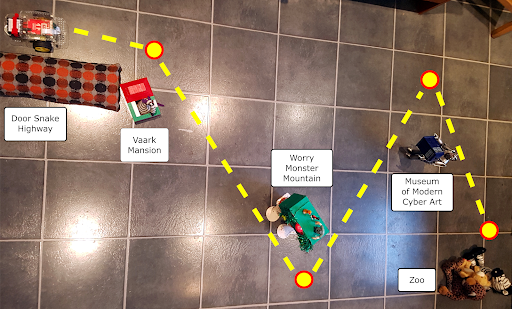

The instructions you're about to send should make the robot travel like this (visually):

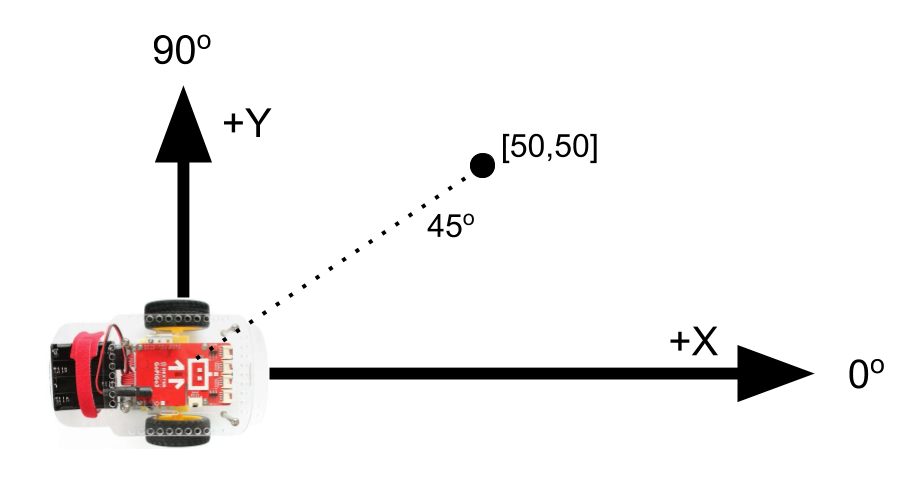

In [ ]:
#testing drive
heading=0
location1=[0,0]
location2=[50,50] #this will drive from 0,0 (facing 0 degrees) to 50,50

drive(heading,location1,location2)

### The rest of the finite states

Now it is time to introduce the other finite states that this robot will use to operate. They have already been programmed for you, but just to get an understanding of how they work, we'll test them below.

#### scan_object(grid=False, graph=False)

The first is the *scan_object()* function. It will use the distance sensor in I2C mounted on a servo plugged into port Servo1 to scan for objects in front of the robot. It will then return the width and location of an object in front of it. If you wish, setting the variables graph and grid to true in the arguments of this function will print an occupancy map and a distance vs angle plot from the data gathered by the function. 

Place a cup-sized object (like a coffee mug, opaque tall cup, or a bluetooth speaker) in front of your robot and run the code below. 

In [ ]:
def scan_object(grid=False,graph=False):

    ###SCAN PARAMETERS###
    scan_center=100
    scan_step=5
    scan_width=120
    zero_position=scan_center-(scan_width//2)

    ###ARRAY INIT.###
    distances=np.array([])
    angles=np.array([])

    ###SCAN###
    for i in range(scan_width//scan_step):
        #scan from right to left
        angle=zero_position+i*scan_step
        my_servo.rotate_servo(angle)
        distances=np.append(distances,my_distance_sensor.read())
        angles=np.append(angles,angle)
        time.sleep(0.01)

    ###OBJECT WIDTH CALCULATION###
    normalized_distances=normalize_min_max(distances) #normalize distance data
    if len(normalized_distances)==0:
        return([300,0],0)
    object_angles=angles[np.where(normalized_distances<0.1)] #get the angles where it 'sees the object'
    object_angular_width=np.max(object_angles)-np.min(object_angles) #calculate the width of that range of angles
    min_dist=distances[np.where(angles==object_angles[len(object_angles)//2])] #find the distance to the 'center' of the object
    object_width=2*min_dist*np.tan((object_angular_width*np.pi/180)/2) #do trig to figure out the object width
    
    ###OBJECT LOCATION CALCULATION###
    min_angle=np.average(object_angles) #min angle is center of object_angles
    object_heading=min_angle-scan_center
    dx = min_dist*np.cos((object_heading*np.pi/180)) #dx found using trig
    dy = min_dist*np.sin((object_heading*np.pi/180)) #dy found using trig (note left of bot is positive)
 
    if grid: #Verbose output prints an occupancy map 
        
        grid_dist=50 #occupancy map params
        grid_size=15
        grid_step=grid_dist/grid_size
        
        np.set_printoptions(threshold=np.inf)
        grid = np.zeros([grid_size,grid_size])
        for i in range(grid_size): #create the occupancy map
            for j in range(grid_size):
                DX=(grid_size-i)*grid_step-dx
                DY=(grid_size/2-j)*grid_step-dy
                dist = np.sqrt((DX)**2 + (DY)**2)
                if dist<=object_width/2:
                    grid[i][j]=1
        
        print(((grid_size//2 * 3)-5)*'_'+'50 x 50 cm view'+((grid_size//2 * 3)-5)*'_')
        print(grid) #print the occupancy map
        print(((grid_size//2 * 3)+1)*'_'+'^^^^'+((grid_size//2 * 3))*'_')
        print(((grid_size//2 * 3))*'_'+'GoPiGo'+((grid_size//2 * 3))*'_')
        
    if graph: #and a distance vs angle plot
        
        plt.figure(0) #plot the distance vs angle plot
        plt.plot(angles,distances)
        plt.plot(np.min(object_angles),min_dist,marker=">",markersize=5,color='red')
        plt.plot(min_angle,min_dist,marker='o', markersize=5, color="red")
        plt.plot(np.max(object_angles),min_dist,marker="<",markersize=5,color='red')
        plt.show()
    
    return([dx,dy],object_width)

(object_location,object_width)=scan_object(graph=True,grid=True)

print('I think the object is %f cm in front of me and %f cm offset from my centerline'%(object_location[0],object_location[1]))
print('I think the object is %f cm wide'%object_width)


#### avoid(heading,location1,object_location,object_width)

Next is the *avoid()* function. This function will use the data from the scan_object() function to determine how to drive around the object we've placed in front of our bot. It also keeps track of how far it drives in reference to our starting location (location1) during this avoidance process. 

Put your object back in front your robot and run the code below. It should first scan the object and then drive around it!

In [ ]:
def avoid(heading, location1, object_location, object_width):
    
    object_dist = object_location[0] #see how close our object is
    dI = my_easy_robot.read_encoders_average() #get distance driven before object
    my_easy_robot.reset_encoders() #reset the encoders before our orbit
    
    orbit_radius = object_dist+object_width/2+15 #calculate how large of an orbit to make
    
    if object_location[1]>=0: #if object is to our left, go right or if it is center
        my_easy_robot.turn_degrees(90)
        my_easy_robot.orbit(-180,orbit_radius) #orbit the object
        my_easy_robot.turn_degrees(90)
    elif object_location[1]<0:
        my_easy_robot.turn_degrees(-90)
        my_easy_robot.orbit(180,orbit_radius) #orbit the object
        my_easy_robot.turn_degrees(-90)
    
    dO = (my_easy_robot.read_encoders_average()*2)/np.pi #get distance driven "through" object
    my_easy_robot.reset_encoders() #reset encoders

    dx = (dI+dO)*(np.cos(heading*np.pi/180)) #calculate the change in x and y 
    dy = (dI+dO)*(np.sin(heading*np.pi/180))

    location1 = [location1[0]+dx,location1[1]+dy] #update location
    
    return(location1)

heading=0
location1=[0,0]

(object_location,object_width)=scan_object(grid=True,graph=True)
print('I think the object is %f cm in front of me and %f cm offset from my centerline'%(object_location[0],object_location[1]))
print('I think the object is %f cm wide'%object_width)
print('I am now doing to drive around the object.')
location1=avoid(heading,location1,object_location,object_width)


### Putting it all together

Now, we will create a loop in which the robot operates, with *triggers* to send it into the different finite states. Think about what should trigger the robot to switch into one of the three states. Follow the instructions in the code below to create our flow from state to state.

In [ ]:
#NOTE: THIS CODE IS NOT MEANT TO BE RUN, IT WILL PRODUCE ERRORS. 

'''
These blocks of code below are out of order. 
They need to be copied and pasted into the spaces in the code block after this one.
Think about what each block does and where it should go in our finite state
machine code.

Paste the correct blocks into the correct spaces in the code bock after this one.
Spaces are denoted like this:

==============Space 1=================
            Block goes here
======================================'''


'''---------------Block A------------------'''
#Block for CHECKING FOR OBJECTS IN FRONT 
reading=my_distance_sensor.read() #get the reading from the sensor  
if reading<=concern_distance: #if our reading is below concern dist
    print('Saw object!')
    my_easy_robot.stop() #stop the GPG
    driving=False #turn driving state off
    scanning=True  #turn scanning state on
'''----------------------------------------'''

'''---------------Block B------------------'''
#Block for STARTING TO DRIVE FROM REST
print("Driving ahead!")
driving=True #Turn driving on
(heading)=drive(heading,location1,location2) #start driving!
'''----------------------------------------'''

'''---------------Block C------------------'''
#Block for AVOIDING AN OBJECT IN FRONT
print('Avoiding object...')
location1=avoid(heading,location1,object_location,object_width) #avoid the object
avoiding=False #Turn avoiding back off
driving=False #Keep driving off, it will turn back on when it sees we aren't doing anything
'''----------------------------------------'''

'''---------------Block D------------------'''
#Block for SCANNING AN OBJECT IN FRONT
print('Scanning object...')
(object_location,object_width)=scan_object(grid=True,graph=True) #scan the object
scanning=False #Turn scanning back off
avoiding=True #Turn avoiding on
'''----------------------------------------'''


Paste the correct blocks into the spaces in the code below. **Make sure the code is correctly indented!** Edit the map list to have your robot drive to the points that you would like it to! 

Run the code after you are done and see what happens!

In [ ]:
###FINAL CODE, PASTE BLOCKS INTO SPACES WITH EQUALS SIGNS AND RUN THIS CODE

##VARIABLES## Don't change
object_position=[300,0]
object_width=0
heading=0
step=-1
concern_distance=15

'''----------------------------------------'''
##Your orienteering map!##
'''Your robot will drive to the points on this map sequentially,
to add a point, make sure to add a comma after the last one'''
MAP=[
    [0,0], #always start at 0,0
    #point format:
    #[x,y],
    #the last point should not have a comma
    [150,0] 
]
'''----------------------------------------'''

###STATES INIT###
driving=True
scanning=False
avoiding=False

###MAIN LOOP###
while True:
    
    #DRIVING: FALSE, SCANNING: FALSE, AVOIDING: FALSE
    if not driving and not scanning and not avoiding: 
        '''================Space 1================='''
        #If we aren't doing anything, we should start driving!

        
        '''========================================'''
    
    #DRIVING: TRUE, SCANNING: FALSE, AVOIDING: FALSE
    elif driving and not scanning and not avoiding:
        '''===============Space 2=================='''
        #Check to see if there's an object!
        #if there is, we should turn off driving and turn on scanning
  

        '''========================================'''
        
        #Otherwise, check to make sure we're still driving
        #Don't worry about the code behind this part. 
        first=my_easy_robot.read_encoders_average()
        time.sleep(0.1)
        second=my_easy_robot.read_encoders_average()
        if first==second:
            print('Finished move.')
            step=step+1
            driving = False
            my_easy_robot.stop()
            location1=MAP[step]
            try:
                location2=MAP[step+1]
            except IndexError:
                break #leave the loop when we're done following directions
    
    #DRIVING: FALSE, SCANNING: TRUE, AVOIDING: FALSE
    elif not driving and scanning and not avoiding:
        '''===============Space 3=================='''
        #If we are scanning an object, 

        
        '''========================================'''
    
    #DRIVING: FALSE, SCANNING: FALSE, AVOIDING: TRUE
    elif not driving and not scanning and avoiding:
        '''===============Space 4=================='''
        #If we are avoiding an object,

        
        '''========================================'''

my_easy_robot.stop()
print('Done.')